# Coffee Review Cleaning and EDA

In [2]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_colwidth', 100)
plt.style.use("ggplot")
mpl.rcParams['figure.figsize'] = (12, 6)
mpl.rcParams['figure.dpi'] = 300


In [3]:
df = pd.read_json('data/raw-roast-reviews.json').replace('NA', np.nan)

In [4]:
def split_price_currency(df):
     # Regular expression pattern to extract the price value from the 'price' column
    currency_pattern = r'\$?(\d+\.\d+|\d+)'
    
    # Extract the 'price' column and split it into 'price' and 'currency' columns
    price = df['price']
    df['price'] = price.apply(lambda x: re.search(currency_pattern, str(x)).group(1) if re.search(currency_pattern, str(x)) else None)
    df['currency'] = price.apply(lambda x: re.sub(currency_pattern, '', str(x)) if re.search(currency_pattern, str(x)) else str(x)).str.strip()
    return df
    
def currency_clean(df):
    
    # Mapping of currency symbols to ISO 4217 codes
    curr_map = {'#': 'GBP', '£':'GBP', '¥': 'CNY', '':'USD', 'pesos':'MXN', 'RMB':'CNY'}

    # Standardize currency values by replacing symbols and mapping to ISO codes
    df.loc[(df['currency'] == '$') | (df['currency'].str.lower().str.contains('us', na=False)), 'currency'] = 'USD'
    df.loc[df['currency'].str.lower().str.contains('nt', na=False), 'currency'] = 'TWD'
    df['currency'] = (df['currency']
                      .str.replace('$', '')
                      .replace(curr_map)
                      .str.strip())
    return df
    
def create_quantity_and_units(df):
    """Separate Amount column into a quantity and the units for that quantity. Then 
       converts all quantities to grams."""

    # Regular expression patterns to extract quantity and unit from the 'amount' column
    amount_pat = r'([\d.]+)\s*([a-zA-Z]+)'
    currency_pattern = r'(\d+\.\d+)'

    def convert_to_grams(df):
        # Conversion factors for pounds to grams and ounces to grams
        POUND_TO_GRAM = 453.59
        OUNCE_TO_GRAM = 28.3495

        # Convert quantities to grams based on unit
        df.loc[df['unit'] == 'ounces', 'quantity'] = df['quantity'] * OUNCE_TO_GRAM
        df.loc[df['unit'] == 'pounds', 'quantity'] = df['quantity'] * POUND_TO_GRAM
        df['unit'] = 'grams'
        
        return df
                        
    return (df
            .assign(quantity = df['amount'].str.extract(amount_pat)[0],
                     unit = df['amount'].str.extract(amount_pat)[1],
                    )
            .drop('amount', axis=1)
            .astype({'quantity': 'float'})
            .pipe(convert_to_grams)
            .dropna(subset=['quantity']))

def create_price_usd(df):
    """Create a column converting all prices to USD using recent exchange rates."""
    # Exchange rate mapping for various currencies to USD
    exchange_rate_map = {'TWD' : 0.03, 
                         'CNY': 0.03, 
                         'GBP': 1.27, 
                         'AED':0.27, 
                         'KRW': 0.000752,
                         'HKD':0.13, 
                         'CAD': 0.74,
                         'MXN': 0.06,
                         'IDR': 0.000065,
                         'AUD': 0.65,
                         'USD': 1.0}
    df['price_usd'] = np.round(df['price'] * df['currency'].map(exchange_rate_map), 2)
    return df
    
def tweak_coffee(df):
    return (df
        # Rename columns, remove spaces, and convert to lowercase
        .rename(columns = lambda c: c.replace(' ', '_'))
        .rename(columns = lambda c: c.replace(':', ''))
        .rename(columns = lambda c: c.lower().strip())
        .rename(columns = {'name': 'roast_name', 'est._price': 'price'})
        .drop_duplicates(subset=['roaster', 'roast_name'])
        # Convert 'review_date' to datetime, handle missing 'acidity/structure' values
        # split agtron measurements, split price and amount
        .assign(review_date = lambda df_: pd.to_datetime(df_['review_date'], format='mixed'),
                acidity = lambda df_: df_['acidity/structure'].fillna(df_['acidity']),
                agtron_external = lambda df_: df_['agtron'].str.split('/', expand=True)[0],
                agtron_ground = lambda df_: df_['agtron'].str.split('/', expand=True)[1],
                amount = lambda df_: df_['price'].str.split('/', expand=True)[1],
                price = lambda df_: df_['price'].str.replace(',', '').str.split('/', expand=True)[0],
                )
        .applymap(lambda x: x.strip() if isinstance(x, str) else x)
        .dropna(subset=['coffee_origin'])
        # Perform price and currency-related processing
        .pipe(split_price_currency)
        .pipe(currency_clean)
        # Extract quantity and units, convert quantities to grams
        .pipe(create_quantity_and_units)
        .drop(['acidity/structure', 'agtron', 'with_milk'], axis=1)
        .replace('NA', np.nan)
        .dropna(subset=['acidity', 'roast_level', 'aroma', 'price','agtron_external', 'agtron_ground',
                        'aftertaste'])
        .astype({'roaster': 'category', 'rating': 'int8', 'roast_level':'category',
                 'aftertaste': 'int8', 'aroma': 'int8', 'body': 'int8',
                 'flavor': 'int8', 'currency':'category', 'acidity': 'int8',
                 'agtron_external': 'int16', 'agtron_ground': 'int16', 'price':'float',
                 'unit': 'category'})
        # Agtron values must fall between 0 and 120 
        .query('agtron_external >= 0 and agtron_external < 120')
        .query('agtron_ground >=0 and agtron_ground < 120')
        # Convert prices to USD and calculate $USD/gram
        .pipe(create_price_usd)
        .assign(price_per_g_usd = lambda df_: np.round(df_['price_usd']/df_['quantity'], 2))
        .reset_index(drop=True)
    )
        
roasts = tweak_coffee(df)
roasts.sample(10)


,roaster_location,coffee_origin,roast_level,price,review_date,aroma,body,flavor,aftertaste,rating,roaster,roast_name,url,acidity,agtron_external,agtron_ground,currency,quantity,unit,price_usd,price_per_g_usd
1645,"Lincoln, California",Guatemala,Medium,17.99,2019-12-01,9,8,8,7,90,San Francisco Bay Coffee,La Finca Medina of Guatemala,https://www.coffeereview.com/review/guatemala-2/,8,47,63,USD,340.194,grams,17.99,0.05
941,"Oakland, California","Dalat, Vietnam",Medium-Light,22.00,2021-09-01,9,9,9,8,93,VN Beans,Hung Farm,https://www.coffeereview.com/review/hung-farm/,8,58,76,USD,340.194,grams,22.00,0.06
2370,"Orlando, Florida","Boquete growing region, western Panama",Medium,46.95,2016-12-01,9,9,9,8,93,Geisha Coffee Roaster,El Burro Geisha Washed “Tachi”,https://www.coffeereview.com/review/el-burro-geisha-washed-tachi/,8,48,64,USD,340.194,grams,46.95,0.14
4165,"Ramsey, Minnesota","Sidamo Province, southern Ethiopia.",Light,17.00,2010-03-01,9,8,9,8,92,Paradise Roasters,Ethiopia Sidamo Ardi,https://www.coffeereview.com/review/ethiopia-sidamo-ardi/,8,74,99,USD,12.000,grams,17.00,1.42
943,"Chicago, Illinois","Ngila Estate, Ngorongoro Conservation Area, Tanzania",Medium-Light,25.00,2021-09-01,9,9,9,8,93,Big Shoulders Coffee,Tanzania Ngila Estate,https://www.coffeereview.com/review/tanzania-ngila-estate/,8,60,78,USD,340.194,grams,25.00,0.07
1606,"Taipei, Taiwan","Gedeb District, Gedeo Zone, southern Ethiopia",Medium,600.00,2020-02-01,9,9,9,8,94,Quartet Kaffe,Ethiopia Violent Andromeda Natural,https://www.coffeereview.com/review/ethiopia-violent-andromeda-natural/,9,48,66,TWD,200.000,grams,18.00,0.09
1301,"Manassas, Virginia","Jarabacoa, Dominican Republic",Medium,12.99,2020-11-01,9,8,9,8,92,Cafe Kreyol,Organic Red Honey Ramirez Estate Microlot,https://www.coffeereview.com/review/organic-red-honey-ramirez-estate-microlot/,8,52,68,USD,340.194,grams,12.99,0.04
2201,"Palo Alto, California","Yirgacheffe growing region, southern Ethiopia",Medium-Light,12.99,2017-10-01,8,9,9,8,92,Red Giant Coffee Roasters,Ethiopia Yirgacheffe Chelelektu,https://www.coffeereview.com/review/ethiopia-yirgacheffe-chelelektu-2/,8,52,74,USD,226.796,grams,12.99,0.06
2160,"Driftless, Wisconsin","Hambela District, Guji Zone, Oromia Region, southern Ethiopia",Medium-Light,18.00,2017-11-01,9,8,9,8,93,Wonderstate Coffee,Organic Ethiopia Kirite,https://www.coffeereview.com/review/organic-ethiopia-kirite/,9,58,81,USD,340.194,grams,18.00,0.05
3456,"Vancouver, British Columbia, Canada",Northern Thailand.,Medium-Dark,55.00,2013-02-01,9,8,9,7,91,Doi Chaang Coffee,Doi Chaang Wild Civet Passed Coffee,https://www.coffeereview.com/review/doi-chaang-wild-civet-passed-coffee/,8,46,55,CAD,50.000,grams,40.70,0.81


In [5]:
# Cleaning up roaster location data

us_states = ['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 
             'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 
             'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 
             'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 
             'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 
             'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 
             'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 
             'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 
             'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 
             'West Virginia', 'Wisconsin','Wyoming']

canadian_provinces = ["Alberta","British Columbia", "Manitoba","New Brunswick", 
                      "Newfoundland and Labrador", "Nova Scotia", "Ontario",
                      "Prince Edward Island", "Quebec", "Saskatchewan",
                      "Northwest Territories","Nunavut","Yukon"]

us_states = [s.lower() for s in us_states]
canadian_provinces = [p.lower() for p in canadian_provinces]   

# Process roaster location by splitting city, state, and country into their own columns.
# Fix typos and standardize.
locations = (roasts['roaster_location']
             .str.strip()
             .str.lower()
             .str.replace("’", "")
             .str.replace("'", "")
             .str.replace(".","")
             .str.split(',', expand=True)
             .apply(lambda row: row.str.strip())
             .replace({'californiaa': 'california', 'calfornia': 'california',
                       'washingto': 'washington', 'virginia and floyd': 'virginia'})
            )

# Cleaning up typos and other small idiosyncracies
locations.loc[locations[0] == "branford connecticut", 1] = "connecticut"
locations.loc[locations[0] == "branford connecticut", 0] = "branford"
locations.loc[locations[0] == "los angeles", 1] = "california"
locations[2] = locations[2].fillna(locations[1])
locations.loc[locations[1].isin(us_states),2 ] = 'usa'
locations.loc[locations[1].isin(canadian_provinces), 2] = 'canada'
locations[1] = locations[1].where(~(locations[1] == locations[2]), np.nan)
locations.loc[locations[2].isin(['hawaii', 'big island of hawaii', 'kona']), 1] = 'hawaii'
locations.loc[locations[2].isin(['hawaii', 'big island of hawaii', 'kona']), 2] = 'usa'
locations.loc[locations[2] == 'dc', 1] = 'dc'
locations.loc[locations[2] == 'dc', 2] = 'usa'
locations.loc[locations[0] == 'peoria illinois', 1] = 'illinois'
locations.loc[locations[0] == 'peoria illinois', 0] = 'peoria'
locations.loc[locations[2] == 'british colombia', 1] = 'british columbia'
locations.loc[locations[2] == 'british colombia', 2] = 'canada'
locations[2] = locations[2].replace('england', 'united kingdom')

locations = locations.rename(columns = {0:'roaster_city', 1:'roaster_state', 2:'roaster_country'})

In [6]:
# Cleaning up coffee origin location. 
origin = (roasts["coffee_origin"]
 .str.split(',').str[-1]
 .str.lower()
 .str.strip()
 .str.replace(r'[-"‘\'.\“\”\’]', '', regex=True)
 .str.replace('southern', '')
 .str.replace('south-central', '')
 .str.replace('western', '')
 .str.replace('southwest', '')
 .str.replace('central', '')
 .str.replace('northern', '')
 .str.replace('eastern', '')
 .str.replace('southern', '')
 .str.replace('north', '')
 .str.replace('west', '')
 .str.replace('east', '')
 .str.replace('far', '')
 .str.replace('papua', '')
 .str.replace('the', '')
 .apply(lambda s: s.replace('south', '') if 'africa' not in s else s)
 .str.strip()
 .rename('origin')
)

origin.loc[origin.str.contains(';')] = 'multiple'
origin.loc[origin.str.contains('hawaii')] = 'hawaii'
origin.loc[origin.str.contains('ethiopia')] = 'ethiopia'
origin.loc[origin.str.contains('congo')] = 'democratic republic of the congo'
origin.loc[origin.str.contains('apaneca')] = 'el salvador'
origin.loc[origin.str.contains('sumatra')] = 'sumatra'
origin.loc[origin.str.contains('colombia')] = 'colombia'
origin.loc[origin.str.contains('latin america')] = 'latin america'
origin.loc[origin.str.contains('ecuador')] = 'ecuador'
origin.loc[origin.str.contains('kenya')] = 'kenya'
origin.loc[origin.str.contains('new guinea')] = 'new guinea'
origin.loc[origin.str.contains('and')] = 'multiple'
origin = origin.replace({'america':'usa', '': np.nan, 'gedeo zone':'ethiopia',
                         'coastal  california':'usa', 'not disclosed':np.nan,
                        'minas gerais state':'brazil', 'guatemalae':'guatemala',})

origin.value_counts()

origin
ethiopia                            969
kenya                               438
colombia                            420
multiple                            325
guatemala                           272
panama                              222
indonesia                           207
costa rica                          198
hawaii                              177
el salvador                         125
brazil                               81
honduras                             77
peru                                 73
nicaragua                            70
burundi                              61
ecuador                              51
mexico                               50
new guinea                           35
yemen                                33
bolivia                              33
tanzania                             31
democratic republic of the congo     27
taiwan                               26
philippines                          15
haiti                            

In [7]:
# Combine cleaned roaster location and coffee origin columns with main dataframe
df = (pd
      .concat([roasts, origin, locations], axis=1)
      .drop(['roaster_location', 'coffee_origin'], axis=1)
      .astype({'origin':'category', 'roaster_city':'category',
               'roaster_state':'category', 'roaster_country':'category'})
     )


df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4184 entries, 0 to 4183
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   roast_level      4184 non-null   category      
 1   price            4184 non-null   float64       
 2   review_date      4184 non-null   datetime64[ns]
 3   aroma            4184 non-null   int8          
 4   body             4184 non-null   int8          
 5   flavor           4184 non-null   int8          
 6   aftertaste       4184 non-null   int8          
 7   rating           4184 non-null   int8          
 8   roaster          4184 non-null   category      
 9   roast_name       4184 non-null   object        
 10  url              4184 non-null   object        
 11  acidity          4184 non-null   int8          
 12  agtron_external  4184 non-null   int16         
 13  agtron_ground    4184 non-null   int16         
 14  currency         4184 non-null   categor

In [8]:
df.to_csv('data/clean-roast-reviews.csv', index=False)

## EDA

### Descriptive Statistics:
Calculate **basic statistics** like **mean, median, and standard deviation** for the 'Rating,' 'Aroma,' 'Acidity,' 'Body,' 'Flavor,' 'Aftertaste,' and 'Price' columns to get an overall understanding of the dataset. Find out how often different roasters and locations appear in the dataset. 

### Distributions:
Visualize the **distributions** of 'Rating,' 'Aroma,' 'Acidity,' 'Body,' 'Flavor,' and 'Aftertaste' using to understand the spread of values.

### Correlations:
Investigate the **correlations** between different attributes such as 'Rating,' 'Aroma,' 'Acidity,' 'Body,' 'Flavor,' and 'Aftertaste.' Identify which attributes tend to go together or have an impact on the overall rating.

### Top Roasters and Coffees:
Identify the top-rated roasters and coffee names based on the 'Rating' column. 

### Quantity Analysis:
Investigate the 'Quantity' and 'Unit' columns to understand the different packaging sizes and units in which coffee is sold. Analyze how these factors relate to pricing and consumer preferences.

### Roaster Performance:
Evaluate roasters' performance based on their ratings and the origin of the coffee beans. Are there specific regions or origins associated with higher ratings for particular roasters?

## Deeper Analysis:

### Geospatial Analysis:
Analyze the 'Roaster_Location' and 'Origin' columns to understand where the roasters are located and where the coffee beans are sourced from. You can use geospatial tools to create maps or investigate the relationship between origin and rating.

### Currency Analysis:
Analyze the 'Currency' column to understand the currencies used for pricing. You can convert prices to a common currency (e.g., USD) for comparison.

### Price Analysis:
Analyze the relationship between 'Price' and 'Rating.' Do higher-priced coffees tend to have higher ratings? You can also look for outliers in pricing.Investigate the relationship between pricing ('Price' and 'Currency') and sensory attributes ('Aroma,' 'Acidity,' 'Body,' 'Flavor,' 'Aftertaste'). Are there pricing strategies associated with higher ratings?

### Text Analysis:
Perform natural language processing (NLP) on the 'Review_Description,' 'Blind_Assessment,' and 'Notes' columns to extract insights about the sensory descriptions, flavor profiles, and unique characteristics of the coffees.

In [9]:
# Basic description.
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4184 entries, 0 to 4183
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   roast_level      4184 non-null   category      
 1   price            4184 non-null   float64       
 2   review_date      4184 non-null   datetime64[ns]
 3   aroma            4184 non-null   int8          
 4   body             4184 non-null   int8          
 5   flavor           4184 non-null   int8          
 6   aftertaste       4184 non-null   int8          
 7   rating           4184 non-null   int8          
 8   roaster          4184 non-null   category      
 9   roast_name       4184 non-null   object        
 10  url              4184 non-null   object        
 11  acidity          4184 non-null   int8          
 12  agtron_external  4184 non-null   int16         
 13  agtron_ground    4184 non-null   int16         
 14  currency         4184 non-null   categor

,price,review_date,aroma,body,flavor,aftertaste,rating,acidity,agtron_external,agtron_ground,quantity,price_usd,price_per_g_usd
count,4184.000000,4184,4184.000000,4184.000000,4184.000000,4184.000000,4184.000000,4184.000000,4184.000000,4184.000000,4184.000000,4171.000000,4171.000000
mean,324.741656,2017-09-22 15:14:27.304015104,8.711520,8.459369,8.869264,8.056405,92.456979,8.355880,54.445268,73.193834,289.228528,20.826389,0.144853
min,3.300000,2009-02-01 00:00:00,4.000000,6.000000,1.000000,3.000000,67.000000,3.000000,0.000000,18.000000,1.000000,1.800000,0.010000
25%,15.500000,2014-03-01 00:00:00,8.000000,8.000000,9.000000,8.000000,92.000000,8.000000,52.000000,69.000000,226.796000,14.000000,0.040000
50%,19.000000,2018-02-01 00:00:00,9.000000,8.000000,9.000000,8.000000,93.000000,8.000000,56.000000,76.000000,340.194000,17.500000,0.060000
75%,30.637500,2021-06-01 00:00:00,9.000000,9.000000,9.000000,8.000000,94.000000,9.000000,60.000000,79.000000,340.194000,21.660000,0.090000
max,120000.000000,2023-09-01 00:00:00,10.000000,10.000000,10.000000,10.000000,98.000000,10.000000,86.000000,105.000000,2721.540000,280.000000,7.500000
std,3927.173740,NaN,0.574543,0.563681,0.562491,0.611213,2.263444,0.652162,10.196603,9.548344,120.303908,15.311203,0.340774


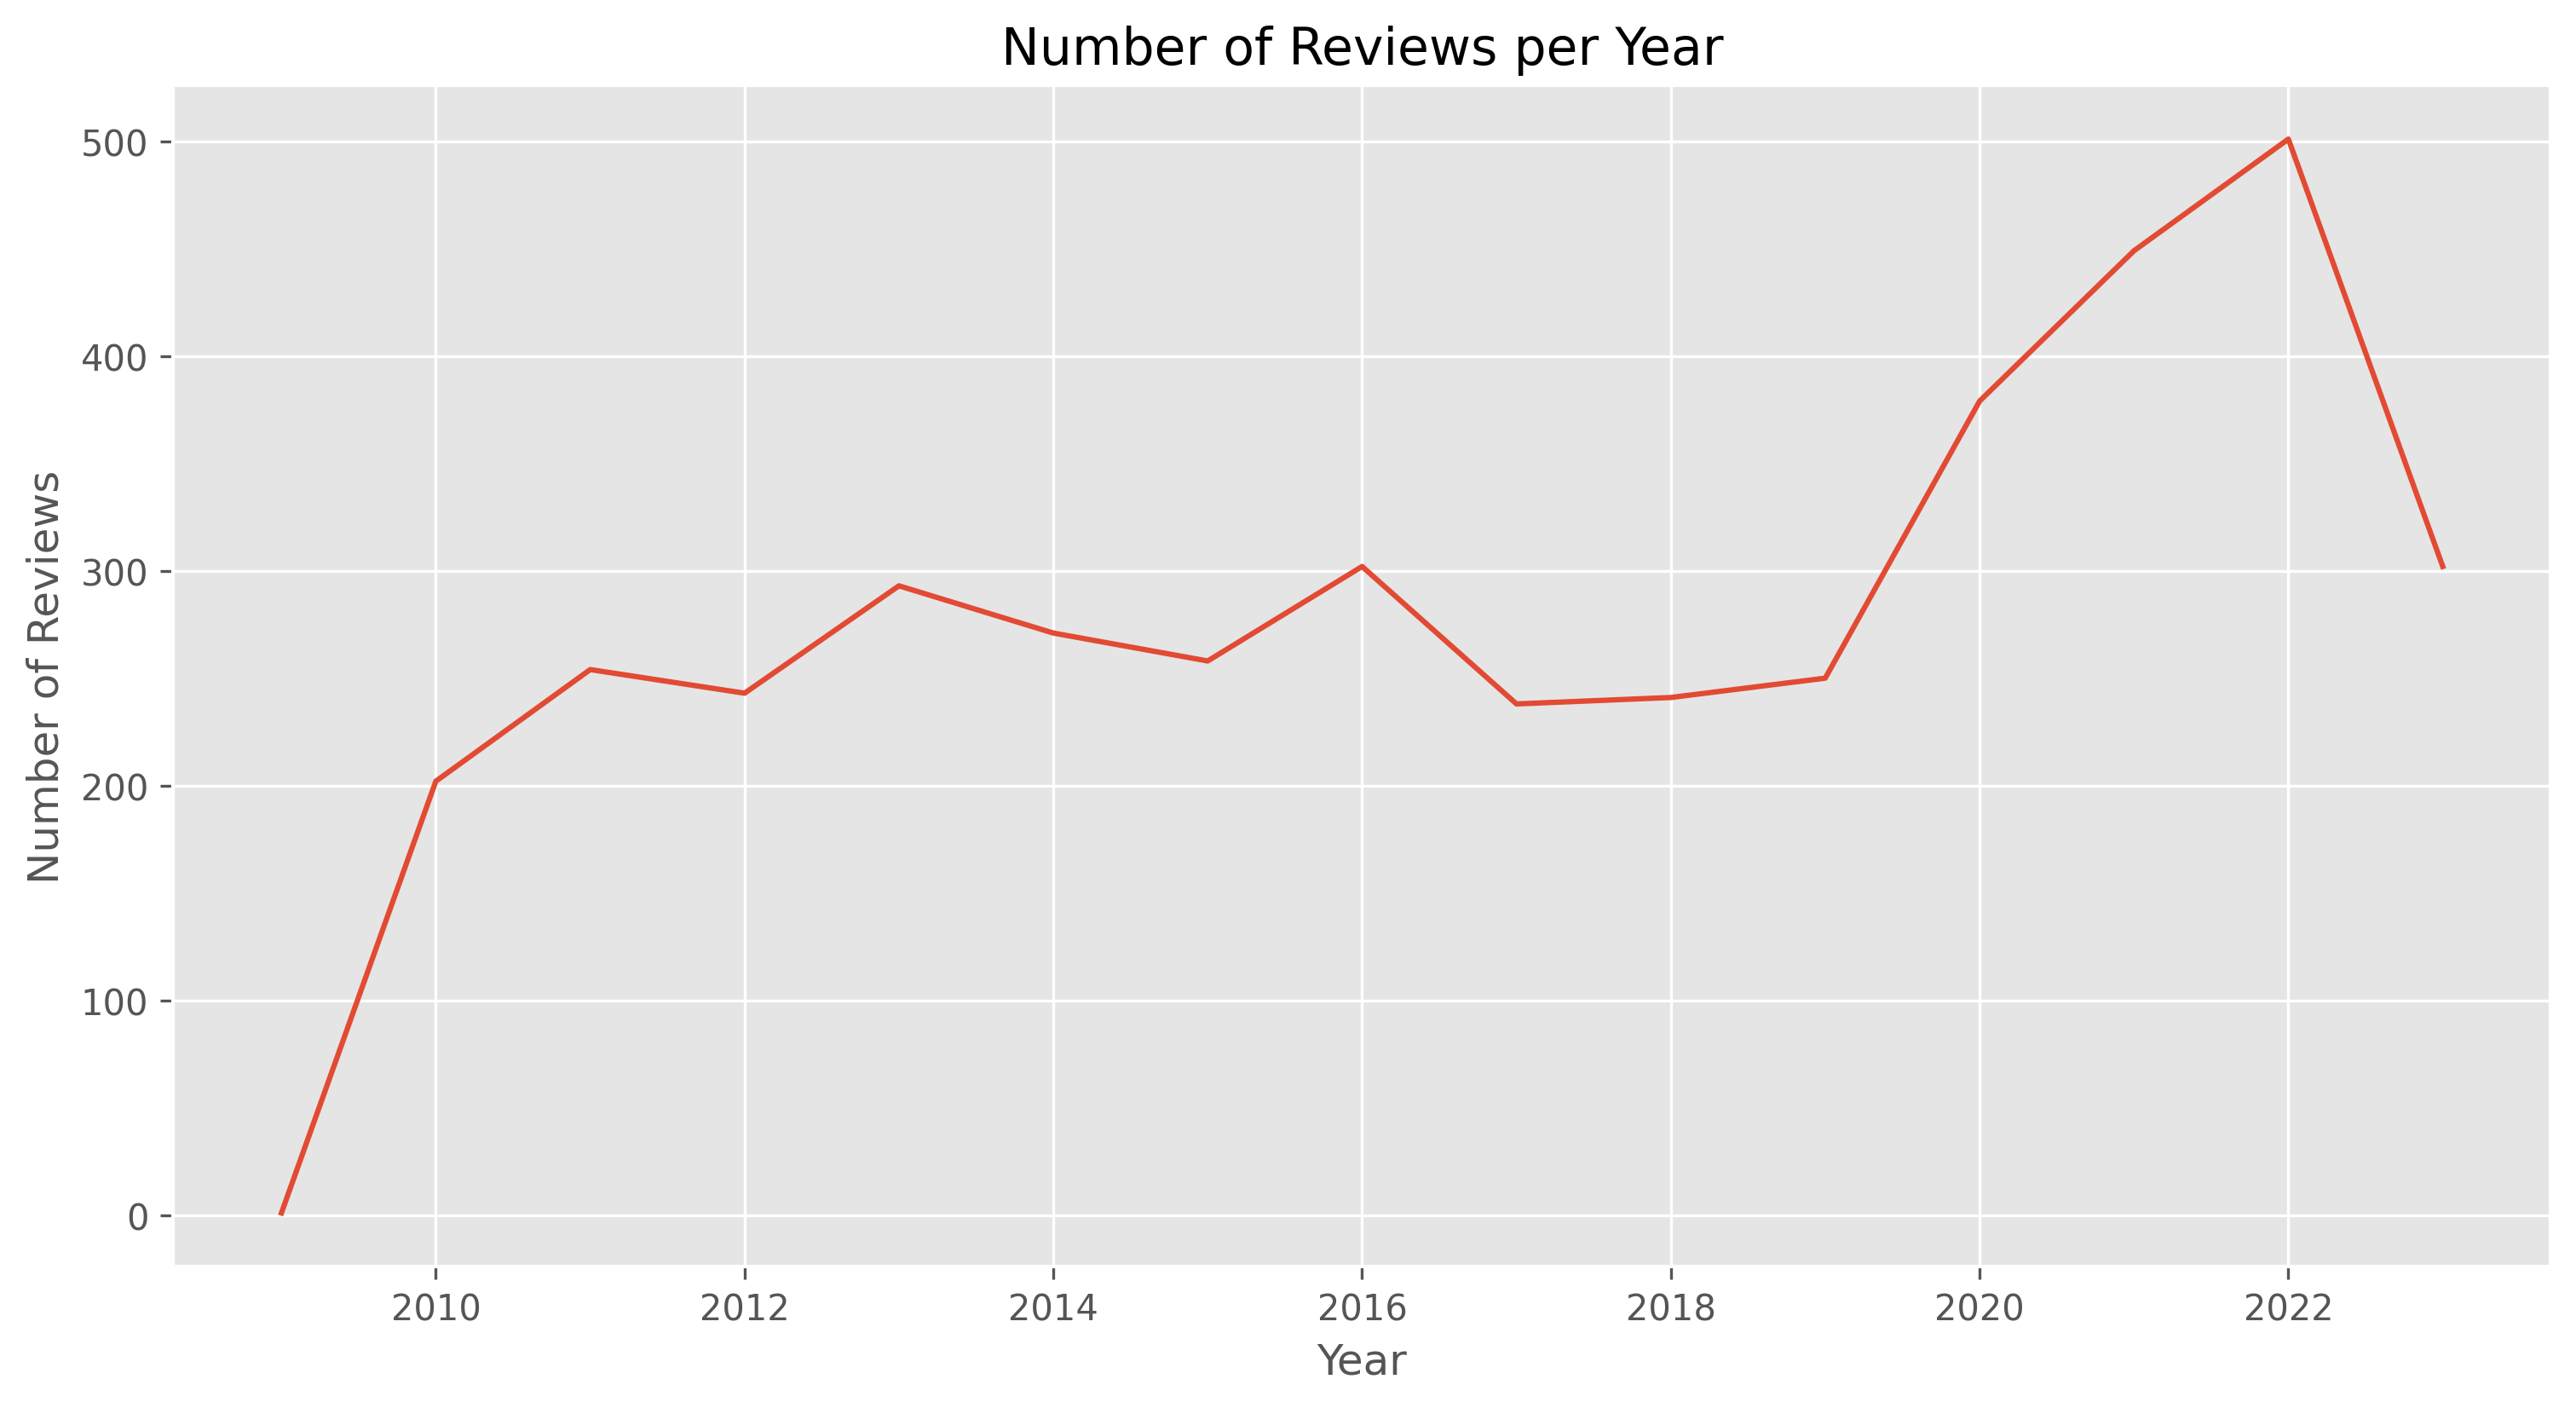

In [10]:
# PLot number of reviews per year. Plot Cumulative number of reviews on top of that.
# plot cumulative reviews over years in seaborn

fig, ax = plt.subplots()
year = df['review_date'].dt.year.value_counts().sort_index()
cumsum = df['review_date'].dt.year.value_counts().sort_index().cumsum()
sns.lineplot(x=year.index, y=year, ax=ax, )
ax.set_title('Number of Reviews per Year')
ax.set_xlabel('Year')
ax.set_ylabel('Number of Reviews')
plt.show()

In [11]:
# Plot number of reviews of origin and roaster
# Compare origin and roaster locations
# heatmap of numerical column correlations
# Pairplot of numerical columns 

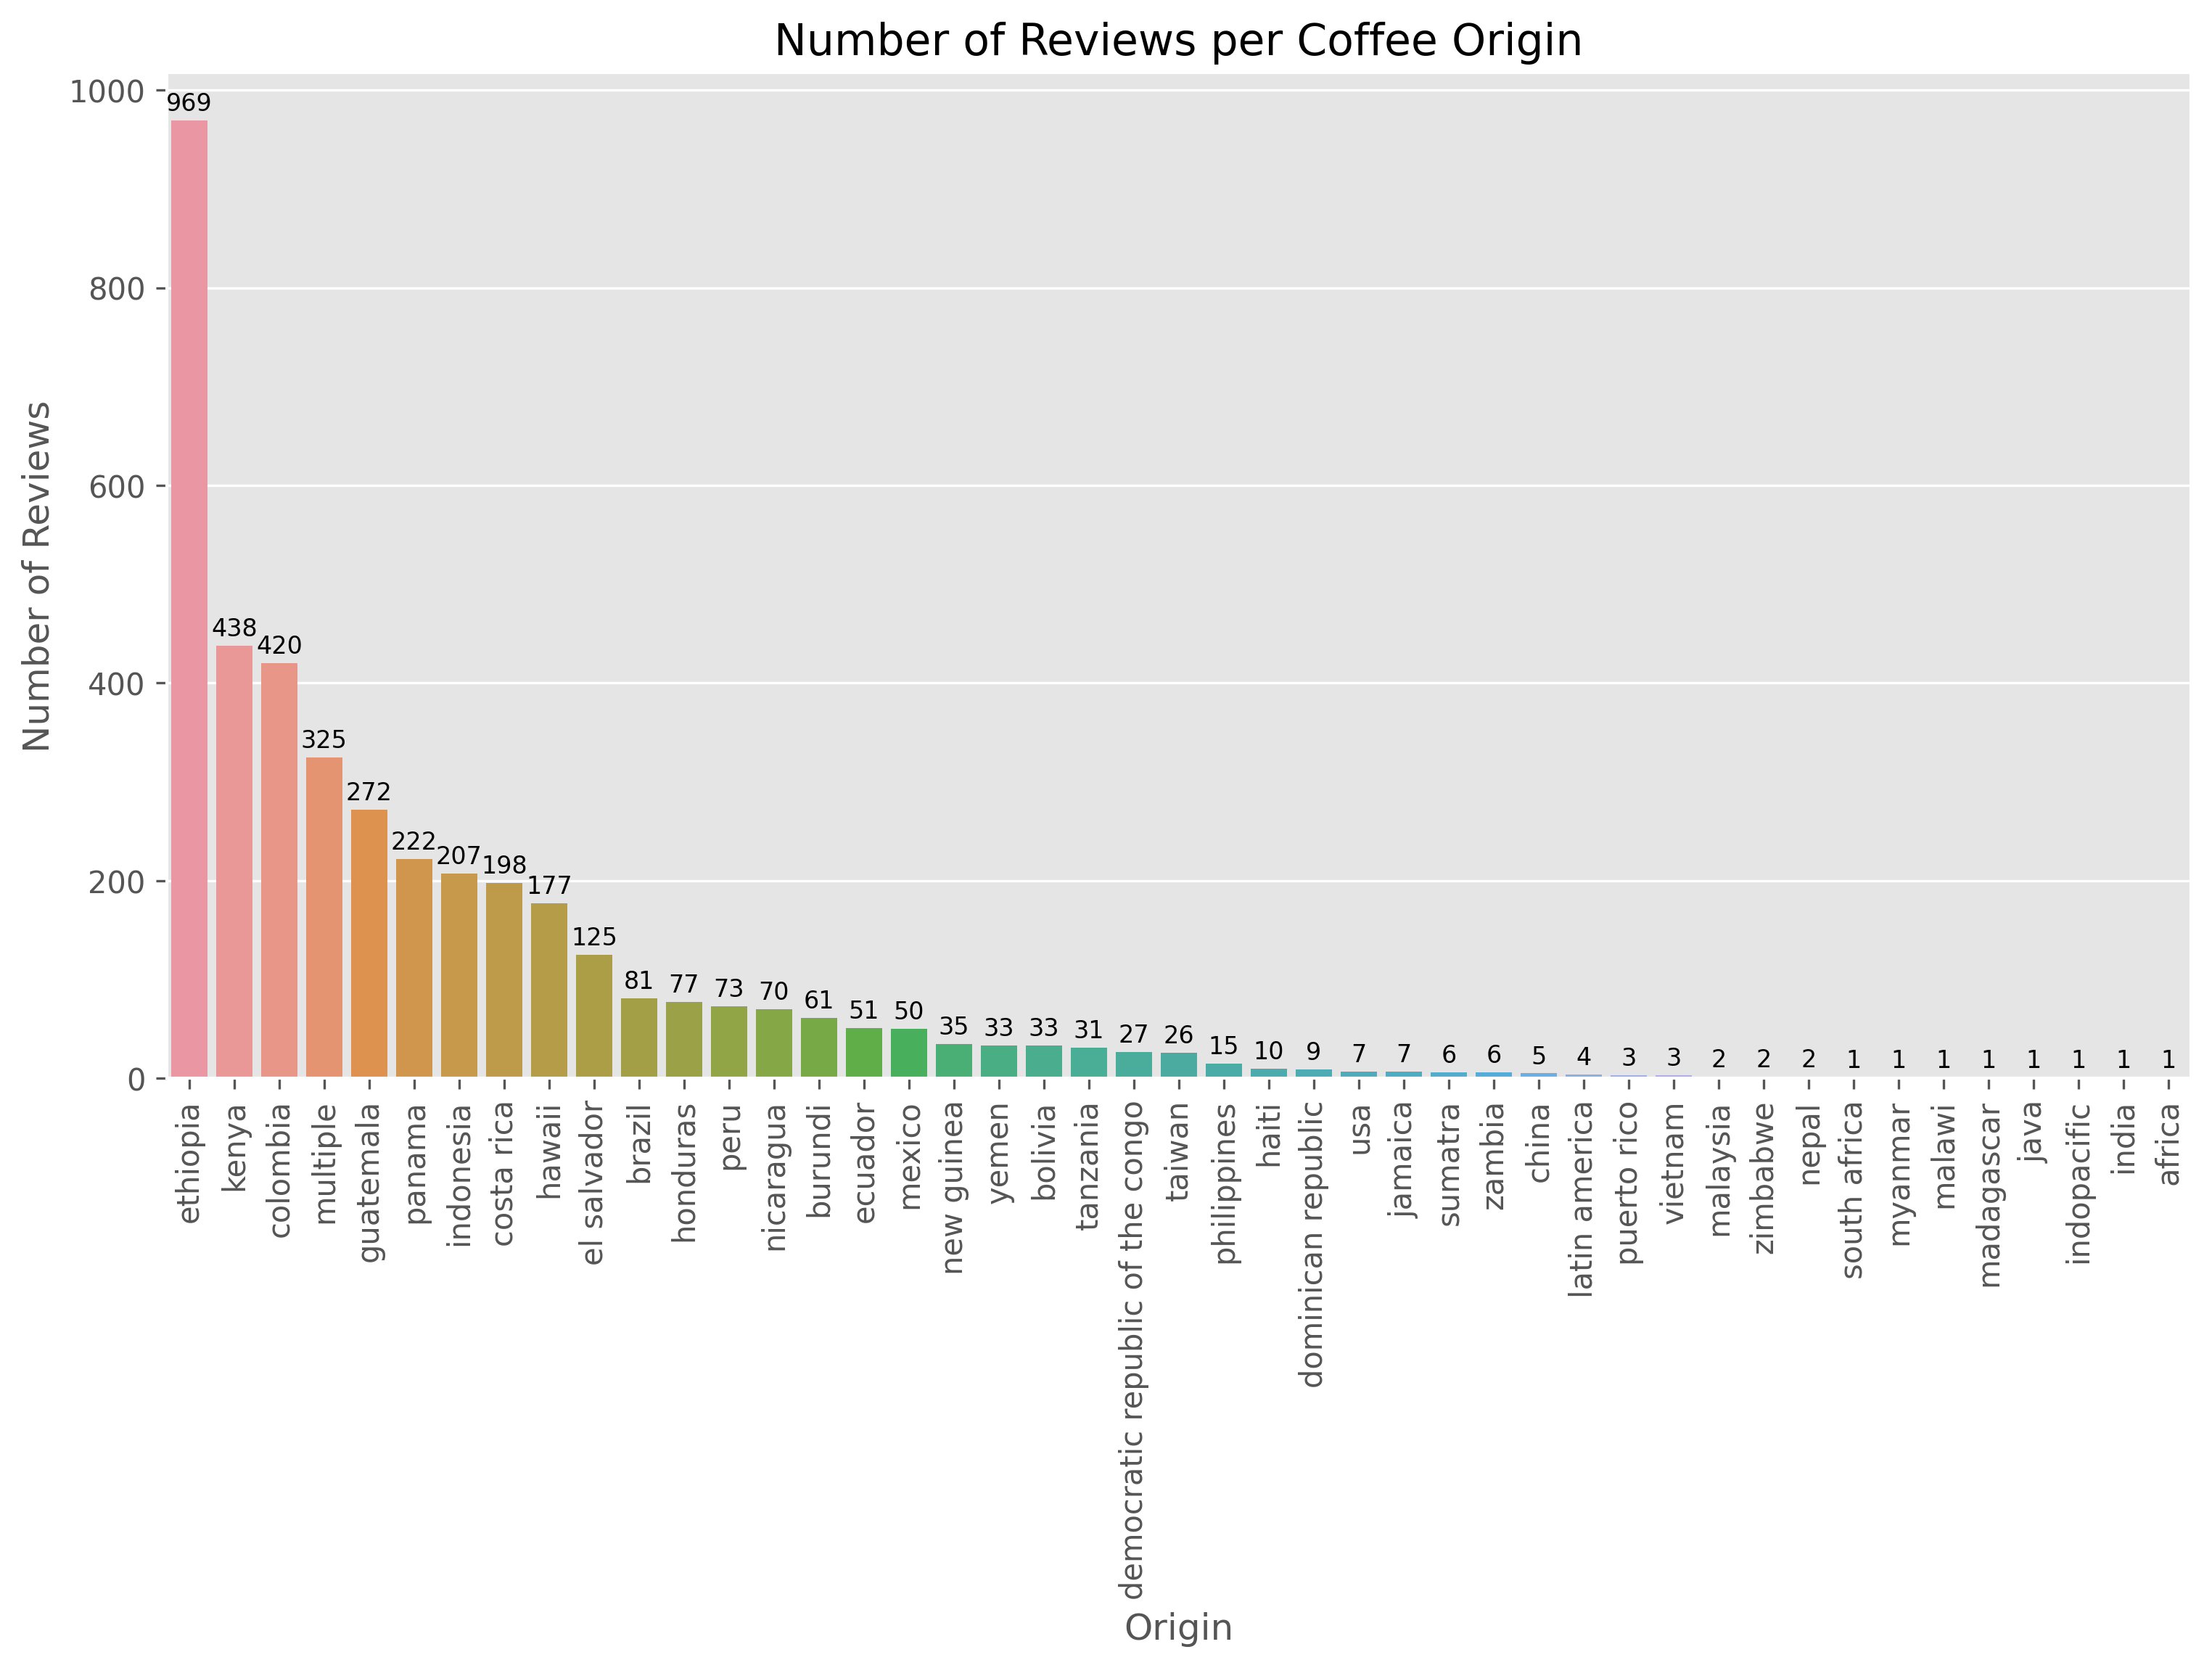

In [12]:
# plot number of reviews per origin ordred by number of reviews

fig, ax = plt.subplots()
origin = df['origin'].value_counts().sort_values(ascending=False)
sns.barplot(x=origin.index, y=origin, ax=ax, order=origin.index)
ax.set_title('Number of Reviews per Coffee Origin')
ax.set_xlabel('Origin')
ax.set_ylabel('Number of Reviews')
plt.xticks(rotation=90)

# add number value above the bars
for i, v in enumerate(origin):
    ax.text(i, v+10, str(v), ha='center', fontsize=8)

plt.show()


In [13]:
df["origin"].value_counts().sort_values(ascending=False)

origin
ethiopia                            969
kenya                               438
colombia                            420
multiple                            325
guatemala                           272
panama                              222
indonesia                           207
costa rica                          198
hawaii                              177
el salvador                         125
brazil                               81
honduras                             77
peru                                 73
nicaragua                            70
burundi                              61
ecuador                              51
mexico                               50
new guinea                           35
yemen                                33
bolivia                              33
tanzania                             31
democratic republic of the congo     27
taiwan                               26
philippines                          15
haiti                            

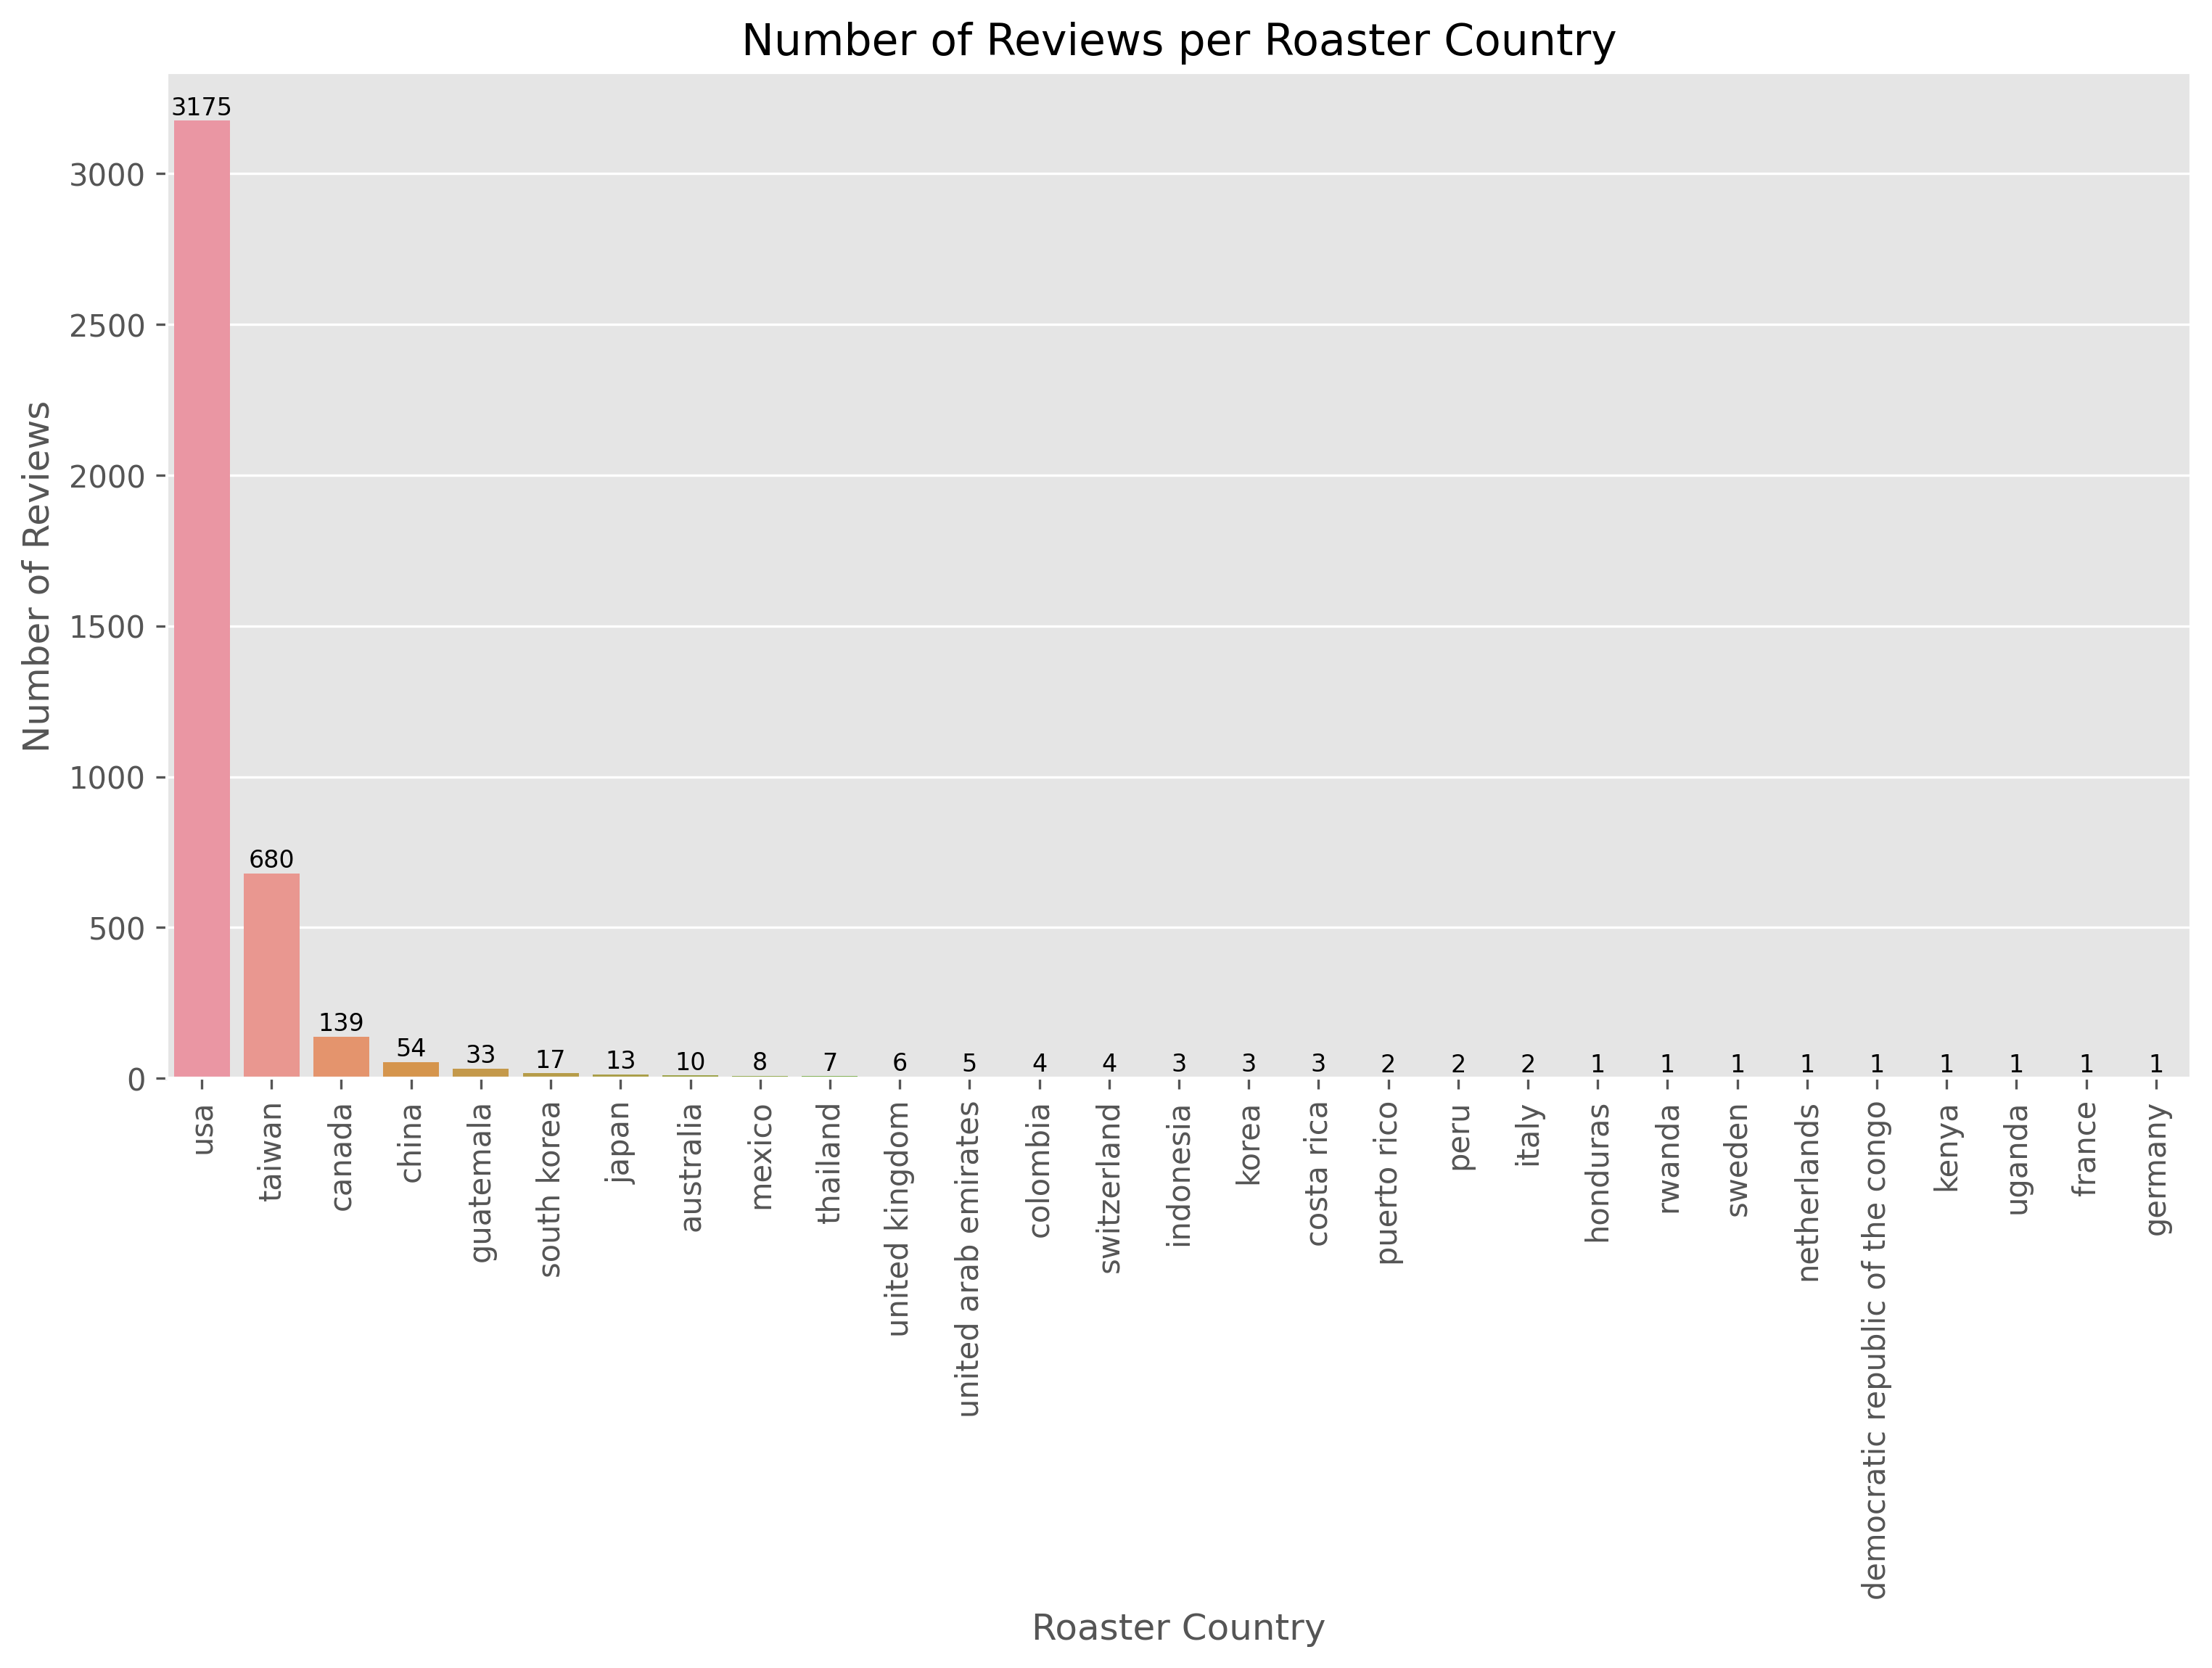

In [15]:
# plot number of reviews per roaster_country ordered by number of reviews

fig, ax = plt.subplots()
country = df['roaster_country'].value_counts().sort_values(ascending=False)
sns.barplot(x=country.index, y=country, ax=ax, order=country.index)
ax.set_title('Number of Reviews per Roaster Country')
ax.set_xlabel('Roaster Country')
ax.set_ylabel('Number of Reviews')
plt.xticks(rotation=90)

for i,v in enumerate(country):
    ax.text(i, v+20, str(v), ha='center', fontsize=8)
plt.show()

